# 🤖 **Pipeline de Minería de Datos Jurídicos con Embeddings y Modelos Generativos**
Este notebook ofrece un flujo de trabajo completo y reproducible para analizar fichas jurisprudenciales o resúmenes de sanciones con técnicas de minería de texto y machine learning. Como estudio de caso, procesa sanciones por infracciones al GDPR extraídas de enforcementtracker.com (CMS Law.Tax, CC BY-NC-SA 4.0), pero es fácilmente adaptable a cualquier otro dataset de textos jurídicos o administrativos.

# Script 00 - Configuración Inicial

In [ ]:
# =========================================================================
# Script 0 — Configuración inicial reproducible (para Google Colab 2024‑25)
#
# ¿Qué hace este script?
# Objetivos:

#   - Instalar todas las dependencias necesarias para el pipeline.
#   - Fijar la semilla de los experimentos para garantizar reproducibilidad.
#   - Guardar en disco una configuración global (config.json) que otros notebooks puedan recargar.
#   - Verificar la conexión con la API de OpenAI y la generación de embeddings (sanity‐check).
#
# ¿Por qué?
#   - Asegura que cualquiera que abra este notebook use exactamente las mismas versiones de librerías y parámetros.
#   - Facilita la traza de los experimentos: puedes volver a correrlos con la misma semilla.
#   - Detecta desde el inicio problemas de conexión o credenciales con OpenAI.
#
# Requisitos previos:
#   1. Python ≥ 3.8 (Colab ya lo proporciona).
#   2. OpenAI API Key:
#      • Genera el token en https://platform.openai.com → API Keys → Create new secret key.
#      • Permite autenticar y usar servicios de OpenAI (embeddings, GPT, etc.).
#      • Guárdalo en un `.env` o introdúcelo interactivamente.
#
# Librerías externas y su función:
#   - openai         : Cliente oficial de la API de OpenAI.
#   - python-dotenv  : (Opcional) Carga variables de entorno desde un `.env`.
#   - tqdm           : Barras de progreso (útil en batchs).
#   - matplotlib     : Gráficos (usado más adelante).
#   - scikit-learn   : Algoritmos de clustering, SVD, métricas.
#   - joblib         : Serialización de modelos (p.ej. KMeans).
#
# Librerías estándar de Colab (preinstaladas):
#   - numpy, pandas : Cálculos numéricos y manejo de tablas.
#   - os, sys, platform, random, json, time : Utilidades del sistema.
#
# Flujo del Script:
#   1) Instalar dependencias.
#   2) Importar librerías y chequear versiones.
#   3) Fijar semilla para reproducibilidad.
#   4) Crear directorio `outputs/`.
#   5) Obtener OpenAI API Key.
#   6) Guardar parámetros en `outputs/config.json`.
#   7) Sanity‐check de embeddings: generar y guardar vectores de prueba.
# =========================================================================

# 1) Instalación de dependencias externas clave
!pip install --quiet openai python-dotenv tqdm matplotlib scikit-learn joblib

# 2) Imports y chequeo del entorno de ejecución
import os
import sys
import platform
import random
import json
import time

import numpy as np
import pandas as pd
from getpass import getpass

print("✅ Versión de Python:", sys.version.split()[0])
print("✅ Plataforma       :", platform.platform())
print("✅ Numpy            :", np.__version__)
print("✅ Pandas           :", pd.__version__)

# 3) Fijar semilla de experimentos para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 4) Crear directorios de trabajo
BASE_DIR   = "/content"
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 5) Obtener OpenAI API Key
#    - Si usas python-dotenv, asegúrate de tener un .env con OPENAI_API_KEY
#    - Si no, introdúcela de forma interactiva:
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("🔑 Ingresa tu OpenAI API Key: ")

# 6) Guardar configuración global en JSON
CONFIG = {
    "seed": SEED,
    "embedding_model": "text-embedding-ada-002",
    "batch_size": 64,
    "max_retries": 5,
    "backoff_base": 2,
    "dataset_csv": "gdpr_fines.csv",
    "text_column": "summary_tfidf",
    "output_dir": OUTPUT_DIR
}

config_path = os.path.join(OUTPUT_DIR, "config.json")
with open(config_path, "w") as f:
    json.dump(CONFIG, f, indent=2)

print(f"🗺️ Configuración guardada en: {config_path}")

# 7) Sanity‐check de embeddings con OpenAI
from openai import OpenAI

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

def embed_batch(texts):
    """
    Genera embeddings con backoff exponencial ante errores.
    Parámetros:
      texts: lista de strings a convertir.
    Retorna:
      lista de vectores (listas de floats).
    """
    for attempt in range(CONFIG["max_retries"]):
        try:
            resp = client.embeddings.create(
                model=CONFIG["embedding_model"],
                input=texts
            )
            return [d.embedding for d in resp.data]
        except Exception as e:
            wait = CONFIG["backoff_base"] ** attempt
            print(f"⚠️ {e}. Reintentando en {wait}s...")
            time.sleep(wait)
    raise RuntimeError("❌ Todos los reintentos de embedding fallaron")

# 8) Prueba de embeddings: generar y guardar vector de ejemplo
test_texts = [
    "GDPR prueba: transparencia y seguridad.",
    "Notificación de brecha de datos."
]

try:
    embs = embed_batch(test_texts)
    arr  = np.array(embs, dtype=np.float32)
    np.save(os.path.join(OUTPUT_DIR, "embedding_prueba.npy"), arr)
    print("✅ Embeddings OK — forma:", arr.shape)
    print("💾 Guardado: outputs/embedding_prueba.npy")
except Exception as e:
    print(f"❌ Error en prueba de embeddings: {e}")

# 9) Nota de uso
print("\nℹ️ Para recargar esta configuración en otro notebook:")
print(f"   with open('{config_path}') as f:\n       CONFIG = json.load(f)")

✅ Versión de Python: 3.11.13
✅ Plataforma       : Linux-6.1.123+-x86_64-with-glibc2.35
✅ Numpy            : 2.0.2
✅ Pandas           : 2.2.2
🗺️ Configuración guardada en: /content/outputs/config.json
✅ Embeddings OK — forma: (2, 1536)
💾 Guardado: outputs/embedding_prueba.npy

ℹ️ Para recargar esta configuración en otro notebook:
   with open('/content/outputs/config.json') as f:
       CONFIG = json.load(f)


# Script 01 - Ingesta y Limpieza

In [ ]:
# ==============================================================================
# Script 1 — Ingesta y limpieza básica reproducible (para Google Colab 2024‑25)
#
# ¿Qué hace este script?
# Objetivos:
#   - Leer el CSV de datos originales.
#   - Renombrar columnas a snake_case para facilitar su uso en Python.
#   - Eliminar duplicados exactos y registros sin texto en la columna principal.
#   - Guardar un archivo Parquet limpio para las siguientes etapas.
#
# ¿Por qué?
#   - Asegura que el dataset esté estructurado y libre de ruido básico.
#   - Parquet es más rápido y eficiente que CSV para lecturas posteriores.
#
# Requisitos:
#   - Tener ejecutado el Script 0 para generar `outputs/config.json`.
#   - Haber subido el CSV (p.ej. `gdpr_fines.csv`) a `/content`.
#
# Flujo:
#   1) Carga configuración global.
#   2) Leer el CSV original y mostrar el conteo inicial.
#   3) Renombrar columnas con espacios/caracteres especiales.
#   4) Eliminar duplicados y filas sin texto en 'summary'.
#   5) Guardar el DataFrame limpio en Parquet.
# ==============================================================================

import os
import json
import pandas as pd

# 1) Carga de configuración
cfg         = json.load(open('/content/outputs/config.json'))
BASE_DIR    = '/content'               # Carpeta raíz en Colab
OUTPUT_DIR  = cfg['output_dir']        # Carpeta de salida configurada en Script 0
DATASET_CSV = cfg['dataset_csv']       # Nombre del archivo CSV de entrada

# 2) Leer CSV original
csv_path = os.path.join(BASE_DIR, DATASET_CSV)
df = pd.read_csv(csv_path)
print(f"📊 Filas originales: {len(df)}")

# 3) Renombrar columnas a snake_case
mapping = {
    'Authority': 'authority',
    'Date': 'date',
    'Fine (€)': 'fine_eur',
    'Controller/Processor': 'entity',
    'Sector': 'sector',
    'Quoted Art.': 'quoted_art',
    'Type': 'violation_type',
    'Summary': 'summary'
}
df = df.rename(columns=mapping)
print("🔄 Columnas renombradas:", df.columns.tolist())

# 4) Eliminar duplicados y registros sin 'summary'
before = len(df)
df = (
    df.drop_duplicates(subset=['authority','date','entity','fine_eur','summary'])
      .dropna(subset=['summary'])
)
print(f"✂️ Eliminadas {before - len(df)} filas; quedan {len(df)}")

# 5) Guardar el DataFrame limpio en Parquet
clean_path = os.path.join(OUTPUT_DIR, 'gdpr_clean.parquet')
df.to_parquet(clean_path, index=False)
print("💾 Parquet limpio guardado en:", clean_path)

# ℹ️ Para replicarlo con otro dataset:
#   • Actualiza 'dataset_csv' en outputs/config.json.
#   • Adapta 'mapping' a tus nombres de columna.
#   • Cambia el 'subset' de drop_duplicates según tus llaves únicas.

📊 Filas originales: 2737
🔄 Columnas renombradas: ['ETid', 'Country', 'authority', 'date', 'fine_eur', 'entity', 'sector', 'quoted_art', 'violation_type', 'summary', 'Source URL', 'Direct URL']
✂️ Eliminadas 17 filas; quedan 2720
💾 Parquet limpio guardado en: /content/outputs/gdpr_clean.parquet


# Script 02 - Limpieza Avanzada y Stopwords

In [ ]:
# =========================================================================
# Script 2 — Limpieza avanzada y stopwords reproducible
#               (para Google Colab 2024-25)
#
# ¿Qué hace este script?
# Objetivos:
#   - Eliminar etiquetas HTML y URLs del texto.
#   - Normalizar caracteres Unicode y pasar a minúsculas.
#   - Eliminar stopwords genéricas (inglés), de dominio específico, de agencias DPA, gentilicios y ruido de clusters.
#   - Filtrar dinámicamente términos que aparecen en más del 70% de los documentos.
#   - Generar una nueva columna `summary_tfidf` lista para vectorización TF-IDF.
#
# Requisitos:
#   - Haber corrido el Script 0 y el Script 1 para disponer de:
#       • outputs/config.json
#       • outputs/gdpr_clean.parquet
#   - Librería `scikit-learn` instalada (vía pip en Script 0).
# =========================================================================

import os
import re
import html
import unicodedata
import json
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

# 1) Cargar configuración y datos
t_cfg = json.load(open('/content/outputs/config.json'))
OUTPUT_DIR = t_cfg['output_dir']
clean_parquet = os.path.join(OUTPUT_DIR, 'gdpr_clean.parquet')
df = pd.read_parquet(clean_parquet)
print(f"📥 Leído Parquet limpio: {clean_parquet}  (n={len(df)})")

# 2) Función de limpieza robusta
def clean_text(txt):
    """
    - Quita etiquetas HTML.
    - Elimina URLs.
    - Normaliza Unicode (NFKC) y pasa a minúsculas.
    - Reemplaza múltiples espacios por uno.
    """
    t = html.unescape(str(txt))
    t = re.sub(r'<[^>]+>', ' ', t)          # eliminar HTML
    t = re.sub(r'https?://\S+', ' ', t)   # eliminar URLs
    t = unicodedata.normalize('NFKC', t).lower()
    return re.sub(r'\s+', ' ', t).strip()

# 3) Aplicar limpieza básica
df['summary_clean'] = df['summary'].apply(clean_text)
print("🔍 Primeros ejemplos de `summary_clean`:")
for sample in df['summary_clean'].head(3):
    print(" •", sample)

# 4) Definir stopwords manuales 🛑
#    - Stopwords en inglés de sklearn
#    - Términos irrelevantes de dominio GDPR
#    - Nombres y siglas de agencias de protección de datos
#    - Gentilicios / nacionalidades
#    - Términos redundantes comunes en todos los clusters

# stopwords generales + dominio
domain_stop = set(ENGLISH_STOP_WORDS) | {
    'eur', 'fine', 'imposed', 'dpa', 'company', 'controller', 'processor'
}

# agencias DPA
agencies_stop = {
    'aepd', 'agpd', 'cnil', 'ico', 'edpb', 'garante',
    'bvd', 'datainspectorate', 'dpd', 'commission', 'authority',
    'commissioner', 'regulator'
}

# gentilicios / nacionalidades
demonyms_stop = {
    'french', 'german', 'italian', 'spanish', 'chilean',
    'polish', 'dutch', 'irish', 'portuguese', 'belgian',
    'austrian', 'romanian', 'bulgarian', 'croatian',
    'czech', 'slovakian', 'hungarian', 'swedish',
    'finnish', 'norwegian', 'danish', 'greek'
}

# ruido compartido de clusters
cluster_noise = {
    'data', 'personal', 'processing', 'information', 'gdpr',
    'subject', 'subjects', 'art', 'dpa', 'aepd', 'company'
}

# unificar todas las stopwords
total_stop = domain_stop | agencies_stop | demonyms_stop | cluster_noise
print(f"🛑 Total stopwords manuales definidas: {len(total_stop)}")

# 5) Filtrado automático con TF-IDF
vectorizer = TfidfVectorizer(
    stop_words=list(total_stop),       # convertir set a lista
    lowercase=False,                   # ya está en minúsculas
    token_pattern=r"(?u)\b[a-záéíóúñü]{2,}\b",
    max_df=0.70,                       # descarta términos en >70% de docs
    ngram_range=(1, 2)
)
# Ajustar para crear vocabulario
dtm = vectorizer.fit_transform(df['summary_clean'])
# Extraer vocabulario depurado
good_terms = set(vectorizer.get_feature_names_out())

# 6) Reconstruir summary_tfidf a partir de vocabulario filtrado
def filter_vocab(txt):
    return ' '.join([w for w in txt.split() if w in good_terms])

df['summary_tfidf'] = df['summary_clean'].apply(filter_vocab)
print("🔍 Primeros ejemplos de `summary_tfidf`:")
for sample in df['summary_tfidf'].head(3):
    print(" •", sample)

# 7) Guardar DataFrame normalizado en Parquet
norm_path = os.path.join(OUTPUT_DIR, 'gdpr_norm.parquet')
df.to_parquet(norm_path, index=False)
print("💾 Parquet normalizado guardado en:", norm_path)

# ℹ️ Para replicar con otro dataset:
#    • Ajusta clean_parquet.
#    • Modifica clean_text según nuevas necesidades.
#    • Enriquecer stopwords o parámetros de vectorizer según el dominio.

📥 Leído Parquet limpio: /content/outputs/gdpr_clean.parquet  (n=2720)
🔍 Primeros ejemplos de `summary_clean`:
 • video surveillance was not sufficiently marked and a large part of the sidewalk of the facility was recorded. surveillance of the public space in this way, i.e. on a large scale by private individuals, is not permitted.
 • cctv was unlawfully used. sufficient information about the video surveillance was missing. in addition, the storage period of 14 days was too long and therefore against the principle of data minimization. addendum: fine has been reduced to eur 1500 by court, see link
 • a dashcam was unlawfully used.
🛑 Total stopwords manuales definidas: 368
🔍 Primeros ejemplos de `summary_tfidf`:
 • video surveillance sufficiently marked large sidewalk facility surveillance public space large scale private
 • cctv unlawfully sufficient video surveillance storage period days long principle reduced link
 • dashcam unlawfully
💾 Parquet normalizado guardado en: /content/outpu

# Script 03 - Generación de Embeddings con API (OpenAI)

In [ ]:
# =========================================================================
# Script 3 — Embeddings OpenAI (robusto, con sanitización y fallback)
# =========================================================================
import os, time, json, unicodedata
import numpy as np
import pandas as pd
from openai import OpenAI, BadRequestError, RateLimitError, APIConnectionError, APIStatusError

# --- Config ---
cfg          = json.load(open('/content/outputs/config.json'))
OUTPUT_DIR   = cfg['output_dir']
MODEL        = cfg.get('embedding_model', 'text-embedding-3-small')  # recomendado
BATCH_SIZE   = int(cfg.get('batch_size', 64))                         # baja para depurar
MAX_RETRIES  = int(cfg.get('max_retries', 5))
BACKOFF_BASE = int(cfg.get('backoff_base', 2))
MAX_CHARS    = int(cfg.get('max_chars_per_item', 8000))               # recorte conservador

print(f"⚙️  Modelo embeddings: {MODEL}")

# --- Datos ---
inp = os.path.join(OUTPUT_DIR, 'gdpr_norm.parquet')
df  = pd.read_parquet(inp)
print(f"📥 Leídos {len(df)} textos desde: {inp}")

# --- Sanitización estricta ---
def sanitize(x: str) -> str:
    if not isinstance(x, str):
        x = "" if x is None else str(x)
    # quita NUL u otros controles problemáticos
    x = x.replace("\x00", " ")
    x = unicodedata.normalize("NFKC", x).strip().lower()
    if not x:
        x = "[no_summary]"
    # recorte conservador por longitud de caracteres
    if len(x) > MAX_CHARS:
        x = x[:MAX_CHARS]
    return x

texts = [sanitize(x) for x in df['summary_tfidf'].tolist()]

client = OpenAI()  # usa OPENAI_API_KEY del entorno

embeddings = []
bad_rows   = []    # para rastrear ítems problemáticos

def embed_batch(batch, batch_start_idx):
    """Intenta el batch; ante 400 descompone por ítem para identificar problemáticos."""
    try:
        r = client.embeddings.create(model=MODEL, input=batch)
        return [d.embedding for d in r.data], []
    except BadRequestError as e:
        # 400: no reintentar ciegamente; probar uno por uno
        print(f"🧪 Batch con 400, probando por ítem… ({str(e)[:120]} …)")
        ok_vecs, bads = [], []
        for j, txt in enumerate(batch):
            try:
                r1 = client.embeddings.create(model=MODEL, input=txt)
                ok_vecs.append(r1.data[0].embedding)
            except BadRequestError as e1:
                global_idx = batch_start_idx + j
                snippet = txt[:160].replace("\n", " ")
                print(f"   ⚠️  ítem {global_idx} inválido: {str(e1)[:100]} | '{snippet}…'")
                bads.append(global_idx)
            except (RateLimitError, APIConnectionError, APIStatusError) as e2:
                # errores transitorios por ítem: espera corta y reintenta una vez
                time.sleep(2)
                try:
                    r1 = client.embeddings.create(model=MODEL, input=txt)
                    ok_vecs.append(r1.data[0].embedding)
                except Exception as e3:
                    global_idx = batch_start_idx + j
                    print(f"   ⚠️  ítem {global_idx} falló de nuevo: {e3}")
                    bads.append(global_idx)
        return ok_vecs, bads
    except (RateLimitError, APIConnectionError, APIStatusError) as e:
        # errores transitorios a nivel de batch: backoff y reintento
        raise e

total_batches = (len(texts) + BATCH_SIZE - 1) // BATCH_SIZE
for b in range(total_batches):
    start = b * BATCH_SIZE
    batch = texts[start:start + BATCH_SIZE]
    attempt = 0
    while True:
        try:
            vecs, bads = embed_batch(batch, start)
            embeddings.extend(vecs)
            bad_rows.extend(bads)
            print(f"✔ Lote {b+1}/{total_batches} → {len(vecs)} emb OK; {len(bads)} err")
            break
        except (RateLimitError, APIConnectionError, APIStatusError) as e:
            attempt += 1
            if attempt > MAX_RETRIES:
                raise RuntimeError(f"Batch {b+1} agotó reintentos: {e}")
            wait = BACKOFF_BASE ** attempt
            print(f"⏳ Transitorio en lote {b+1}: {e}. Reintentando en {wait}s…")
            time.sleep(wait)

# Alinear tamaños: si hubo bad_rows, elimina esas filas de df para mantener índice
if bad_rows:
    print(f"🚫 Ítems descartados por 400: {len(bad_rows)}")
    mask = np.ones(len(df), dtype=bool)
    mask[bad_rows] = False
    df = df.loc[mask].reset_index(drop=True)

# Guardado
emb_array = np.array(embeddings, dtype=np.float32)
emb_path  = os.path.join(OUTPUT_DIR, 'embeddings.npy')
np.save(emb_path, emb_array)
print(f"💾 Embeddings → {emb_path} — shape: {emb_array.shape}")

df['emb_idx'] = np.arange(len(df))
out_df = os.path.join(OUTPUT_DIR, 'df_emb.parquet')
df.to_parquet(out_df, index=False)
print(f"💾 DF → {out_df}")

⚙️  Modelo embeddings: text-embedding-ada-002
📥 Leídos 2720 textos desde: /content/outputs/gdpr_norm.parquet
✔ Lote 1/43 → 64 emb OK; 0 err
✔ Lote 2/43 → 64 emb OK; 0 err
✔ Lote 3/43 → 64 emb OK; 0 err
✔ Lote 4/43 → 64 emb OK; 0 err
✔ Lote 5/43 → 64 emb OK; 0 err
✔ Lote 6/43 → 64 emb OK; 0 err
✔ Lote 7/43 → 64 emb OK; 0 err
✔ Lote 8/43 → 64 emb OK; 0 err
✔ Lote 9/43 → 64 emb OK; 0 err
✔ Lote 10/43 → 64 emb OK; 0 err
✔ Lote 11/43 → 64 emb OK; 0 err
✔ Lote 12/43 → 64 emb OK; 0 err
✔ Lote 13/43 → 64 emb OK; 0 err
✔ Lote 14/43 → 64 emb OK; 0 err
✔ Lote 15/43 → 64 emb OK; 0 err
✔ Lote 16/43 → 64 emb OK; 0 err
✔ Lote 17/43 → 64 emb OK; 0 err
✔ Lote 18/43 → 64 emb OK; 0 err
✔ Lote 19/43 → 64 emb OK; 0 err
✔ Lote 20/43 → 64 emb OK; 0 err
✔ Lote 21/43 → 64 emb OK; 0 err
✔ Lote 22/43 → 64 emb OK; 0 err
✔ Lote 23/43 → 64 emb OK; 0 err
✔ Lote 24/43 → 64 emb OK; 0 err
✔ Lote 25/43 → 64 emb OK; 0 err
✔ Lote 26/43 → 64 emb OK; 0 err
✔ Lote 27/43 → 64 emb OK; 0 err
✔ Lote 28/43 → 64 emb OK; 0 err
✔ Lo

# Script 04 - Clustering K-Means

In [ ]:
# =========================================================================
# Script 4 — Clustering K‑Means y selección de K reproducible
#               (para Google Colab 2024‑25)
#
# ¿Qué hace este script?
# Objetivos:
#   - Cargar los embeddings generados (embeddings.npy) y el DataFrame enlazado (df_emb.parquet).
#   - Evaluar la calidad de clustering para distintos valores de K usando la métrica silhouette.
#   - Seleccionar el K óptimo donde la silhouette es máxima.
#   - Entrenar el modelo K‑Means final y asignar cada documento a un cluster.
#   - Guardar el modelo entrenado, el DataFrame con clusters y los scores de silhouette.
#
# ¿Por qué?
#   - K‑Means permite agrupar documentos similares según su embedding semántico.
#   - El análisis de silhouette ayuda a determinar cuántos clusters representan mejor la estructura de los datos.
#   - Al guardar el modelo y los resultados, se facilita su reutilización y evaluación posterior.
#
# Requisitos:
#   - Haber ejecutado los Scripts 0, 1, 2 y 3 para disponer de:
#       • outputs/config.json
#       • outputs/embeddings.npy
#       • outputs/df_emb.parquet
#   - Tener instalada la librería scikit‑learn (se instaló en Script 0).
#
# Flujo:
#   1) Cargar configuración y datos.
#   2) Para K en el rango 4–16:
#        • Entrenar K‑Means con random_state fijo.
#        • Calcular silhouette_score.
#        • Convertir el score a float nativo y almacenar.
#        • Imprimir la tabla K vs. silhouette.
#   3) Identificar el K óptimo.
#   4) Entrenar K‑Means final con el K óptimo y asignar clusters.
#   5) Guardar:
#        • El objeto K‑Means en kmeans.joblib.
#        • El DataFrame con la columna `cluster` en df_clustered.parquet.
#        • Los scores de silhouette en silhouette.json.
# =========================================================================

import os
import json

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

# 1) Carga de configuración y datos
cfg      = json.load(open('/content/outputs/config.json'))
OUTPUT   = cfg['output_dir']
SEED     = cfg['seed']

# Cargar embeddings y DataFrame enlazado
X  = np.load(os.path.join(OUTPUT, 'embeddings.npy'))
df = pd.read_parquet(os.path.join(OUTPUT, 'df_emb.parquet'))
print(f"📥 Cargados embeddings (shape={X.shape}) y DataFrame (n={len(df)})")

# 2) Evaluar K óptimo usando silhouette
scores = {}
print("K\tSilhouette")
for k in range(4, 17):
    km = KMeans(n_clusters=k, random_state=SEED, n_init='auto')
    labels = km.fit_predict(X)
    sil_score = float(silhouette_score(X, labels))  # convertir a float Python
    scores[k] = sil_score
    print(f"{k}\t{sil_score:.4f}")

# 3) Seleccionar el mejor K
best_k = max(scores, key=scores.get)
print(f"\n📈 K óptimo = {best_k} (Silhouette={scores[best_k]:.4f})")

# 4) Entrenar el modelo final y asignar clusters
km_final = KMeans(n_clusters=best_k, random_state=SEED, n_init='auto')
df['cluster'] = km_final.fit_predict(X)

# 5) Guardar artefactos
model_path      = os.path.join(OUTPUT, 'kmeans.joblib')
df_path         = os.path.join(OUTPUT, 'df_clustered.parquet')
silhouette_path = os.path.join(OUTPUT, 'silhouette.json')

joblib.dump(km_final, model_path)
df.to_parquet(df_path, index=False)
with open(silhouette_path, 'w', encoding='utf-8') as f:
    json.dump(scores, f, indent=2)

print("💾 Artefactos guardados:")
print(f"   • Modelo K‑Means         : {model_path}")
print(f"   • DataFrame con clusters  : {df_path}")
print(f"   • Silhouette scores JSON: {silhouette_path}")

# ℹ️ Para replicar o ajustar:
#   • Modifica el rango de K en el bucle (líneas 27–28).
#   • Prueba otros algoritmos de clustering (reemplaza KMeans por AgglomerativeClustering, etc.).
#   • Cambia la semilla en config.json para explorar estabilidad.

📥 Cargados embeddings (shape=(2720, 1536)) y DataFrame (n=2720)
K	Silhouette
4	0.0543
5	0.0563
6	0.0550
7	0.0561
8	0.0394
9	0.0380
10	0.0327
11	0.0335
12	0.0356
13	0.0370
14	0.0374
15	0.0380
16	0.0388

📈 K óptimo = 5 (Silhouette=0.0563)
💾 Artefactos guardados:
   • Modelo K‑Means         : /content/outputs/kmeans.joblib
   • DataFrame con clusters  : /content/outputs/df_clustered.parquet
   • Silhouette scores JSON: /content/outputs/silhouette.json


# Script 05 - Perfilado Estadístico de Clusters

In [ ]:
# =========================================================================
# Script 5 — Perfilado estadístico de clusters reproducible
#               (para Google Colab 2024‑25)
#
# ¿Qué hace este script?
# Objetivos:
#   - Cargar el DataFrame con clusters asignados.
#   - Tokenizar cada resumen para extraer palabras relevantes.
#   - Contar la frecuencia de tokens y obtener los top-N términos por cluster.
#   - Mostrar ejemplos representativos de cada grupo.
#   - Guardar un JSON con la información de perfil (tamaño, top_terms, ejemplos).
#
# ¿Por qué?
#   - Ayuda a interpretar la semántica de cada cluster.
#   - Facilita la validación manual: ves los términos clave y ejemplos.
#   - Genera un artefacto reusable (`cluster_profile.json`) para informes o dashboards.
#
# Requisitos:
#   - Haber ejecutado los Scripts 0–4 para disponer de:
#       • outputs/config.json
#       • outputs/df_clustered.parquet
#   - Librerías: pandas, numpy, sklearn (instaladas en Script 0).
#
# Flujo:
#   1) Cargar configuración y el DataFrame final con clusters.
#   2) Definir función `tokenize` basada en regex para extraer palabras.
#   3) Definir `top_terms` que cuenta tokens y devuelve los n más comunes.
#   4) Recorrer cada cluster:
#        • Contar documentos.
#        • Extraer top_terms.
#        • Tomar 3 ejemplos de resúmenes.
#   5) Imprimir en pantalla un resumen rápido de cada cluster.
#   6) Guardar el diccionario `profile` en `outputs/cluster_profile.json`.
# =========================================================================

import os
import json
import pandas as pd
from collections import Counter
import re

# 1) Carga de configuración y datos
cfg = json.load(open('/content/outputs/config.json'))
OUTPUT_DIR = cfg['output_dir']
input_path = os.path.join(OUTPUT_DIR, 'df_clustered.parquet')
df = pd.read_parquet(input_path)
print(f"📥 Datos cargados: {input_path} (n={len(df)})\n")

# 2) Tokenización ligera con regex
def tokenize(text):
    """
    Extrae palabras alfabéticas de al menos 3 caracteres,
    incluyendo vocales acentuadas, en minúscula.
    """
    if not isinstance(text, str):
        return []
    return re.findall(r"[a-záéíóúñü]{3,}", text.lower())

# 3) Función para obtener los top-N términos
def top_terms(texts, n=10):
    cnt = Counter()
    for doc in texts:
        cnt.update(tokenize(doc))
    return [term for term, _ in cnt.most_common(n)]

# 4) Construir el perfil de cada cluster
profile = {}
for c in sorted(df['cluster'].unique()):
    cluster_id = int(c)
    docs = df.loc[df['cluster'] == c, 'summary_tfidf'].dropna().tolist()
    profile[cluster_id] = {
        'count': len(docs),
        'top_terms': top_terms(docs, 10),
        'examples': docs[:3]
    }

# 5) Mostrar resultados por pantalla
for cluster_id, info in profile.items():
    print(f"--- Cluster {cluster_id} (n={info['count']}) ---")
    print("Top terms :", info['top_terms'])
    print("Examples  :")
    for ex in info['examples']:
        print(" •", ex)
    print()

# 6) Guardar perfil en JSON
output_path = os.path.join(OUTPUT_DIR, 'cluster_profile.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(profile, f, indent=2, ensure_ascii=False)
print(f"💾 Perfil guardado en: {output_path}")

📥 Datos cargados: /content/outputs/df_clustered.parquet (n=2720)

--- Cluster 0 (n=613) ---
Top terms : ['complaint', 'filed', 'bank', 'consent', 'received', 'failed', 'customer', 'reduced', 'vodafone', 'did']
Examples  :
 • bgn roughly bank calling client unresolved bills provoked client evoke right receiving answer bank filed bank did action statutory client filed complaint infringement bank fined linked consumer credit purpose processed different communicated time conclusion bank point view request additional consent
 • repeated registration prepaid services knowledge consent employees telecommunications provider used registered complainant prepaid signed application consented stated legal basis signature application complainant genuine application identical persons identification number identity card number complainants
 • bank established bank account consent bank supposedly available disposed bank able provide office protection necessary documentation prove entering contract

---

# Script 06 - Visualización 2D de Clusters

📥 Cargados embeddings (2720, 1536) y DataFrame con 2720 registros
✅ Proyección 2D completada
💾 Gráfico guardado en: /content/outputs/clusters_2d.png
💾 Coordenadas exportadas en CSV: /content/outputs/clusters_2d.csv


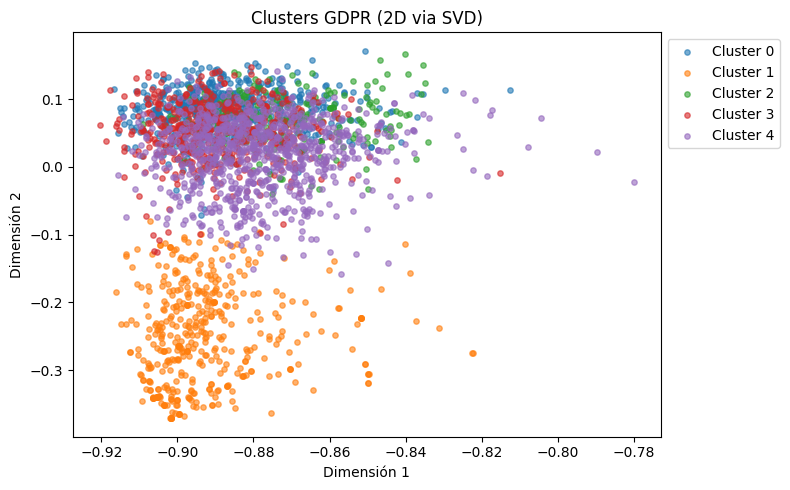

In [ ]:
# =========================================================================
# Script 6 — Visualización 2D de clusters reproducible
#               (para Google Colab 2024‑25)
#
# ¿Qué hace este script?
# Objetivos:
#   - Reducir los embeddings de alta dimensión a 2D usando TruncatedSVD.
#   - Graficar cada cluster en un scatter plot para validar visualmente la separación.
#   - Exportar un archivo de coordenadas (x,y,cluster) para dashboards o análisis adicional.
#
# ¿Por qué?
#   - La proyección 2D facilita inspeccionar solapamientos o grupos bien definidos.
#   - Un gráfico es una herramienta rápida para comunicar resultados.
#   - Las coordenadas exportadas permiten crear visualizaciones interactivas en aplicaciones externas.
#
# Requisitos:
#   - Haber ejecutado los Scripts 0–5 para disponer de:
#       • outputs/config.json
#       • outputs/embeddings.npy
#       • outputs/df_clustered.parquet
#   - Tener instalada la librería scikit‑learn y matplotlib (vía pip en Script 0).
#
# Flujo:
#   1) Cargar configuración, embeddings y DataFrame con clusters.
#   2) Aplicar TruncatedSVD para proyectar a 2 dimensiones.
#   3) Generar un scatter plot coloreando por cluster.
#   4) Guardar la imagen como PNG.
#   5) Exportar un CSV con columnas x, y y cluster.
# =========================================================================

import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# 1) Carga de configuración y datos
cfg = json.load(open('/content/outputs/config.json'))
OUTPUT_DIR = cfg['output_dir']
EMB_PATH   = os.path.join(OUTPUT_DIR, 'embeddings.npy')
DF_PATH    = os.path.join(OUTPUT_DIR, 'df_clustered.parquet')

embs = np.load(EMB_PATH)
df   = pd.read_parquet(DF_PATH)
print(f"📥 Cargados embeddings {embs.shape} y DataFrame con {len(df)} registros")

# 2) Proyección a 2 dimensiones
svd = TruncatedSVD(n_components=2, random_state=cfg['seed'])
xy  = svd.fit_transform(embs)
print("✅ Proyección 2D completada")

# 3) Gráfico de clusters
plt.figure(figsize=(8, 5))
for cluster_id in sorted(df['cluster'].unique()):
    mask = df['cluster'] == cluster_id
    plt.scatter(xy[mask, 0], xy[mask, 1], s=15, alpha=0.6, label=f'Cluster {cluster_id}')
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Clusters GDPR (2D via SVD)')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.tight_layout()

# 4) Guardar la visualización
png_path = os.path.join(OUTPUT_DIR, 'clusters_2d.png')
plt.savefig(png_path, dpi=150)
print("💾 Gráfico guardado en:", png_path)

# 5) Exportar coordenadas para dashboards
coords = pd.DataFrame(xy, columns=['x','y']).assign(cluster=df['cluster'])
csv_path = os.path.join(OUTPUT_DIR, 'clusters_2d.csv')
coords.to_csv(csv_path, index=False)
print("💾 Coordenadas exportadas en CSV:", csv_path)

# ℹ️ Para replicar o ajustar:
#   • Cambia TruncatedSVD por UMAP o PCA para probar otras proyecciones.
#   • Ajusta el tamaño del plot o colores según tu preferencia.

# Script 07 - Generación Automática de Insights con API de OpenAI

In [ ]:
# =========================================================================
# Script 7 — Generación de insights automáticos sin mapeo manual
#               (para Google Colab 2024‑25)
#
# ¿Qué hace?
#   1) Carga resultados de:
#        - cluster_profile.json
#        - silhouette.json
#        - df_clustered.parquet (para ejemplos)
#   2) Monta un prompt con:
#        • Silhouette scores.
#        • Perfiles de clusters: tamaño, top terms y ejemplos (3).
#   3) Llama a la API de OpenAI con streaming para generar:
#        A) Patrones comunes.
#        B) Diferencias clave.
#        C) Recomendaciones prácticas.
#   4) Imprime el informe completo y lo guarda en Markdown.
#
# Requisitos:
#   • Scripts 0–6 ya ejecutados:
#       - outputs/config.json
#       - outputs/cluster_profile.json
#       - outputs/silhouette.json
#       - outputs/df_clustered.parquet
#   • openai >= 1.0.0 instalado, y OPENAI_API_KEY en entorno.
# =========================================================================

import os
import json
import pandas as pd
from openai import OpenAI

# 1) Cargar configuración y artefactos
cfg       = json.load(open('/content/outputs/config.json', 'r', encoding='utf-8'))
OUT       = cfg['output_dir']
profile   = json.load(open(os.path.join(OUT, 'cluster_profile.json'), 'r', encoding='utf-8'))
scores    = json.load(open(os.path.join(OUT, 'silhouette.json'),    'r', encoding='utf-8'))
df        = pd.read_parquet(os.path.join(OUT, 'df_clustered.parquet'))

# 2) Generar texto de perfiles de clusters
profile_text = ""
for cid, info in profile.items():
    # Línea principal con tamaño y top terms
    terms = ", ".join(info['top_terms'])
    profile_text += f"- Cluster {cid} (n={info['count']}): Top terms = [{terms}]\n"
    # Tres ejemplos representativos
    examples = info.get('examples', [])
    for ex in examples[:3]:
        profile_text += f"    • {ex}\n"
    profile_text += "\n"

# 3) Construir prompt usando sólo datos objetivos
prompt = f"""
Eres un analista de datos jurídicos experto. A continuación tienes los resultados cuantitativos del análisis:

1) Silhouette scores por número de clusters:
{json.dumps(scores, ensure_ascii=False, indent=2)}

2) Perfiles de clusters:
{profile_text}

Genera un informe en español que contenga:
A) Patrones comunes en los clusters, en formato de viñetas.
B) Diferencias clave entre clusters, en viñetas.
C) Recomendaciones prácticas para mejorar el análisis y la interpretación.
Termina la sección de recomendaciones con la frase "Fin de recomendaciones.".
"""

# 4) Llamada a la API de OpenAI con streaming y alto límite de tokens
client     = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
model_name = "gpt-3.5-turbo-16k"  # o "gpt-4-32k" si tienes acceso

response = client.chat.completions.create(
    model=model_name,
    messages=[
        {"role": "system", "content": "Eres un analista sénior de datos jurídicos."},
        {"role": "user",   "content": prompt}
    ],
    temperature=0.7,
    max_tokens=1500,
    stream=True
)

# 5) Recolectar, imprimir y guardar el informe completo
full_insight = ""
print("\n===== Informe de Insights Generado por OpenAI =====\n")
for chunk in response:
    piece = chunk.choices[0].delta.content or ""
    print(piece, end="", flush=True)
    full_insight += piece
print("\n===== Fin del Informe =====\n")

# 6) Guardar en Markdown
out_path = os.path.join(OUT, 'general_insights.md')
with open(out_path, 'w', encoding='utf-8') as f:
    f.write("# Informe de Insights del Pipeline\n\n")
    f.write(full_insight)
    f.write("\n\nFin de recomendaciones.\n")

print(f"💾 Insight guardado en: {out_path}")


===== Informe de Insights Generado por OpenAI =====

**Informe de Análisis de Clusters de Datos Jurídicos**

**A) Patrones comunes en los clusters:**
- Los clusters presentan una alta frecuencia de términos relacionados con quejas, consentimiento, incumplimientos y sanciones legales.
- Se observa una presencia significativa de términos relacionados con medidas de seguridad, protección de datos y violaciones de la privacidad.
- Los clusters muestran términos vinculados a la instalación y uso de sistemas de vigilancia, así como a la falta de respuesta o cumplimiento de solicitudes.

**B) Diferencias clave entre clusters:**
- Cluster 0: Enfocado en quejas bancarias, consentimiento y acciones legales.
- Cluster 1: Relacionado con la vigilancia por video y posibles violaciones de principios de privacidad.
- Cluster 2: Se centra en incumplimientos en la provisión de información y respuestas.
- Cluster 3: Destaca medidas técnicas y organizativas de seguridad, así como brechas de seguridad.
-